In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [2]:
# HIPERPARÂMETROS:
start_date = '2013-08-21'
W = 80  # Lembrando que o tamanho do treinamento será W - w
w = 50  

[*********************100%%**********************]  1 of 1 completed


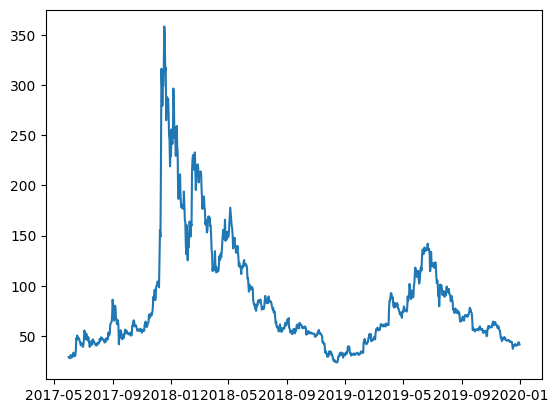

In [3]:
df = yf.download('LTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
plt.plot(df['Close'].loc['2017-06-01':'2019-12-31'])

In [4]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD'
]

In [5]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [6]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    data[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [8]:
for crypto in cryptos:
    data_complete[crypto]['exp_value'] = data_complete[crypto]['Crypto_Return_Today'].shift(1).rolling(window = 14).mean()

In [10]:
data_visual = data_complete

In [15]:
results = []

for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna().loc['2019-05-27':'2019-09-03']
    
    # Cálculos dos valores
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()
    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()

    # Calcula a porcentagem de subidas e quedas reais e previstas
    total_real = num_positive + num_negative
    total_pred = hat_pos + hat_neg
    perc_positive_real = (100 * num_positive / total_real) if total_real > 0 else None
    perc_positive_pred = (100 * hat_pos / total_pred) if total_pred > 0 else None
    
    # Calcular métricas de avaliação
    TP = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] < 0)).sum()
    mae = df['ae'].mean()
    acc = (TP + TN) / (TP + TN + FN + FP) if (TP + FP + FN + FP) > 0 else None
    sen = TP / (TP + FN) if (TP + FN) > 0 else None
    spe = TN / (TN + FP) if (TN + FP) > 0 else None
    pre = TP / (TP + FP) if (TP + FP) > 0 else None

    # Lower bound dos 10% maiores
    limite_90 = df['exp_value'].quantile(0.75)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()

    # Precisão para valores maiores que 0.008
    TP_threshold = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0) & (df['exp_value'] >= menor_valor_10_maiores)).sum()
    FP_threshold = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0) & (df['exp_value'] >= menor_valor_10_maiores)).sum()
    prec_maior_008 = TP_threshold / (TP_threshold + FP_threshold) if (TP_threshold + FP_threshold) > 0 else None

    # Adicionando os resultados para a criptomoeda atual
    results.append({
        "Crypto": crypto,
        "Num Subidas (Real)": num_positive,
        "Perc Subidas (Real)": perc_positive_real,
        "Num Quedas (Real)": num_negative,
        "Num Subidas (Pred)": hat_pos,
        "Perc Subidas (Pred)": perc_positive_pred,
        "Num Quedas (Pred)": hat_neg,
        "MAE": mae,
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "Pre": pre,
        "Lower bound dos 10% maiores": menor_valor_10_maiores,
        "Precisao para maiores que 0.008": prec_maior_008
    })

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibindo a tabela com os resultados

# Exibindo a tabela com os resultados
results_df.to_csv("resultado_baseline.csv", index = True)
results_df

,Crypto,Num Subidas (Real),Perc Subidas (Real),Num Quedas (Real),Num Subidas (Pred),Perc Subidas (Pred),Num Quedas (Pred),MAE,Acc,Sen,Spe,Pre,Lower bound dos 10% maiores,Precisao para maiores que 0.008
0,BTC-USD,56,56.0,44,52,52.0,48,0.035110,0.52,0.535714,0.500000,0.576923,0.011159,0.56
1,ETH-USD,52,52.0,48,38,38.0,62,0.033327,0.48,0.365385,0.604167,0.500000,0.004387,0.56


In [29]:
Pre_media = results_df['Pre'].mean()
Acc_media = results_df['Acc'].mean()
MAE_media = results_df['MAE'].mean()
Precisao_25_media = results_df['Precisao para maiores que 0.008'].mean()
print("Pre_media ", Pre_media)
print("Acc_media ", Acc_media)
print("MAE_media ", MAE_media)
print("Precisao_25_media", Precisao_25_media)

Pre_media  0.36693548387096775
Acc_media  0.45774647887323944
MAE_media  0.029946721843385656
Precisao_25_media 0.4027777777777778


## 3.3 Método 2 para os ultimos X intervalos

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [ ]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)